In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy

In [3]:
from libs.plotting import plot_lcs
from astropy.table import Table

In [4]:
from dataset import radio_3c273, gev_3c273, coincidence_mask_3c273
from dataset import radio_mrk421, gev_mrk421, coincidence_mask_mrk421
from dataset import radio_mrk501, gev_mrk501, coincidence_mask_mrk501

from dataset import radio_3c273_orig, radio_mrk421_orig, radio_mrk501_orig

from dataset import coincidence_checker
import matplotlib.pyplot as plt

In [5]:
def profile_st(x, Amp, t_rise, t_fall, t_shift):
    t = x - t_shift
    return Amp * np.exp(-t/t_fall) / (1 + np.exp(-t/t_rise))

def convolve_arrays_sigma(v1, v2, dv1):
    v1, v2, dv1 = np.array(v1), np.array(v2), np.array(dv1)
    r = np.convolve(v1, v2)
    dr2 = np.convolve(dv1 ** 2, v2 ** 2)
    return r, np.sqrt(dr2)

In [6]:
def prepare_fit(s_data_ds, r_data_ds, bin_size, fit_roi, time_start=None, noplot=False):
    s_data = s_data_ds
    r_data = r_data_ds
    
    s_m, r_m = coincidence_checker(s_data, r_data, bin_size=bin_size)
    
    sd = Table({i:s_data_ds[i][s_m] for i in s_data_ds.columns})
    sd.meta = s_data_ds.meta
    for c in s_data_ds.columns:
        sd[c].unit = s_data_ds[c].unit
    
    rd = Table({i:r_data_ds[i][r_m] for i in r_data_ds.columns})
    rd.meta = r_data_ds.meta
    for c in r_data_ds.columns:
        rd[c].unit = r_data_ds[c].unit
    
    if not noplot:
        plot_lcs(sd, rd, extra_data=[s_data_ds, r_data_ds], highlights=[None, fit_roi], figsize=(10, 6))
    return s_data, r_data, s_m, r_m, bin_size, fit_roi, s_data_ds, r_data_ds, sd, rd


def get_fit(params, 
            configuration, 
            profile_func, 
            t_shift=None, 
            const_flux_present=False, 
            all_uncertainties=False, 
            exclude_roi=[], 
            plot_data=False, 
            curvefit=False, 
            syn_delay=0, 
            result=False,  
            ylims=None, 
            start_time=None, 
            highlight=None,
            plot_timerange=None,
            dst_data=None, 
            color='black',
            extra_data=None,
            extra_color='#1f77b4', #'#11265b',
            filename='tmp.png',
            flare_tuning = None,
            background=None,
            extra_plot=None,
            get_dof = False,
            plot_flares=False
           ):
    s_data, r_data, s_m, r_m, bin_size, fit_roi, s_data_ds, r_data_ds, sd, rd = configuration
    s_t, s_f, s_df = s_data['tc'], s_data['f'], s_data['df']
    r_t, r_f, r_df = r_data['tc'], r_data['f'], r_data['df']
    
    const_flux = 0
    if const_flux_present:
        const_flux = params[-1]
        params = params[:-1]        
    if t_shift is not None:
        params = [*params] + [t_shift]
    prof = profile_func(s_t - min(s_t), *params)
    _params = [i for i in params]
    A0 = params[0]
    syn_t = s_t
    syn_f = np.zeros_like(s_f)
    syn_df = np.zeros_like(s_df)
    if flare_tuning is None:
        syn = convolve_arrays_sigma(s_f.copy(), prof, s_df)
        syn_f = syn[0][:len(s_f)] + const_flux
        syn_df = syn[1][:len(s_f)]
    else:
        fig = None
        if plot_flares:
            fig = plt.figure(figsize=(15,5))
        for f in flare_tuning:
            _time_range, amplitude = f
            _tmp_s_f = np.zeros_like(s_f)
            _tmp_s_df = np.zeros_like(s_df)
            m = np.logical_and(syn_t > _time_range[0], syn_t <= _time_range[1])
            _tmp_s_f[m] = s_f.copy()[m]
            _tmp_s_df[m] = s_df.copy()[m]
            _params[0] = A0 * amplitude
            prof = profile_func(s_t - min(s_t), *_params)
            syn = convolve_arrays_sigma(_tmp_s_f, prof, _tmp_s_df)
            syn_f += syn[0][:len(s_f)]
            syn_df += syn[1][:len(s_f)]**2
            if plot_flares:
                plt.plot(s_t, syn[0][:len(s_f)] + const_flux, '.', label="%s" % _time_range)
        syn_t = s_t   
        if background is not None:
            syn_f += background(s_t, const_flux)
        else:
            syn_f += const_flux
        syn_df = 0*np.sqrt(syn_df)
        if plot_flares:
            plt.legend()
            plt.show()
        
    roi_mask = np.logical_and(r_t[r_m] >= fit_roi[0], r_t[r_m] <= fit_roi[1])
    
    _r_t = r_t[r_m][roi_mask]
    _r_f = r_f[r_m][roi_mask]
    _r_df = r_df[r_m][roi_mask]
    
    _s_t = syn_t[s_m][roi_mask]
    _s_f = syn_f[s_m][roi_mask]
    _s_df = syn_df[s_m][roi_mask]
    
    if curvefit:
        return np.column_stack([_r_t, _r_f, _r_df]), np.column_stack([_s_t, _s_f, _s_df])
    
    delta = _r_df
    if all_uncertainties:
        delta = np.sqrt(_r_df**2 + _s_df**2)
    
    xi = ((_s_f - _r_f)/delta)**2
    xi_t = _s_t
    for p in exclude_roi:
        m = np.logical_and(xi_t >= p[0], xi_t <= p[1])
        xi = xi[~m]
        xi_t = xi_t[~m]
    
    dof = len(xi) - len(params) - (1 if const_flux_present else 0)
    chi2 = np.sum(xi)
    
    if get_dof:
        return chi2/dof, dof
        
    if not plot_data:
        #clear_output(wait=True)
        #display("chi2 = %s (%s), params = %s, delta_t = %s" % (chi2, len(xi), np.array(params), t_shift))
        return chi2/dof
    else:
        p = [i for i in params]
        if const_flux_present:
            p += [const_flux]
            
        print("chi2/dof = %s/%s = %s, params = %s, t_shift=%s" % (chi2, dof, chi2/dof, str(p), t_shift))
    

        syn_full = Table({'tc' : syn_t + syn_delay, 'f' : syn_f, 'df' : syn_df})
        syn_full.meta['title'] = "Synthetic LC"
        syn_full.meta['f_units'] = "Jy"

        sn = Table({'tc' : _s_t + syn_delay, 'f' : _s_f, 'df' : _s_df})
        sn.meta['title'] = "Synthetic LC"
        sn.meta['f_units'] = "Jy"

                
        #plot_lcs(sd, sn, rd, extra_data=[s_data_ds, syn_full, r_data_ds], highlights=[None, fit_roi, fit_roi], figsize=(10, 10), filename='images/gev_syn_radio.eps')
        
        _highlight = fit_roi if highlight is None else highlight
        _dst_data = rd if dst_data is None else dst_data
        
        
        
        def inset_creator(ax):
            x = np.linspace(0, 700, 1000)
            A, t_rise, t_decay, f_const = 197765.3421157885, 19.24416937907919, 42.883458356259524, 26.973314037084446
            delta_t = 255
            p = profile_func(x - min(x), *params)
            ax.plot(x, p/np.max(p))
            ax.set_ylabel("$S/S_{max}$")
            ax.set_xlabel('$t$ (d)')

        
        plot_lcs(s_data, sn, _dst_data, extra_data=extra_data, extra_plot=extra_plot, highlights=[None, _highlight, _highlight, None], extra_color=extra_color, color=color, figsize=(11, 9), ylims=ylims, timerange=plot_timerange, filename=filename, inset_creator=inset_creator, inset_id=1)
       
        return sd, sn, rd, chi2, dof, _r_t, _r_f, _r_df, _s_t, _s_f, _s_df, syn_full

In [7]:
mrk421_timerange = [55500, gev_mrk421.meta['timerange'][1]]
mrk421_plot_timerange = [55200, gev_mrk421.meta['timerange'][1]]

con_f1d = prepare_fit(gev_mrk421, radio_mrk421, bin_size=1, fit_roi=mrk421_timerange, noplot=True)
con_plot = prepare_fit(gev_mrk421, radio_mrk421, bin_size=1, fit_roi=mrk421_plot_timerange, noplot=True)

38.4
chi2/dof = 1592.869197155208/262 = 6.079653424256519, params = [12812.728589788614, 0.05132579894636356, 122.475293347503, 38.4, 0.17876828681103585], t_shift=38.4
Mrk 421 using UL


<ipython-input-5-4fb456198fb8>:3: RuntimeWarning: overflow encountered in exp
  return Amp * np.exp(-t/t_fall) / (1 + np.exp(-t/t_rise))
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


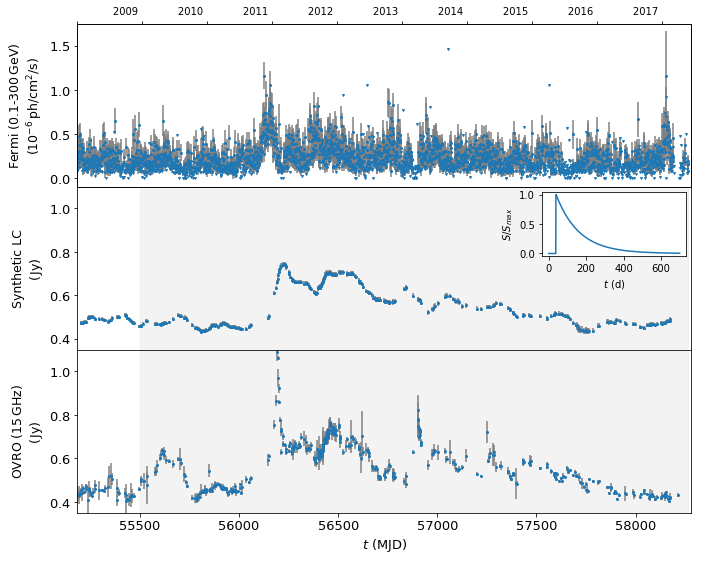

In [8]:
t = 38.4
x = [12812.728589788614, 0.05132579894636356, 122.475293347503, 0.17876828681103585]
print(t)
ylims = [[None, None], [0.35, 1.1], [0.35, 1.1]]
exclude_roi=[
    [55550, 55650],
    [56150, 56250],
    [58850, 58950],
    [57200, 75300]
]
#result = get_fit(x, con_f1d, profile_st, t, True, extra_data=[all_fermi1d, None, None], plot_data=True, ylims=ylims, all_uncertainties=True, exclude_roi=exclude_roi, highlight=[55500, FACT_TIMERANGE[1]], plot_timerange=[55200, FACT_TIMERANGE[1]], dst_data=radio, color='#11265b', filename='images/gev_syn_radio_mrk421.eps')


result = get_fit(x, con_plot, profile_st, t, True, extra_data=[gev_mrk421, None, None], plot_data=True, ylims=ylims, all_uncertainties=True, exclude_roi=exclude_roi, highlight=mrk421_timerange, plot_timerange=mrk421_plot_timerange, dst_data=radio_mrk421_orig, color='#1f77b4', filename='images/gev_syn_radio_mrk421.eps')

In [219]:
#
# threshold 5.9 from https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html, dof=5, P(X<x)=0.68
# print(np.abs(x1 - x0) * 98, x0, x1)
#
params = [38.4, 12812.728589788614, 0.05132579894636356, 122.475293347503, 0.17876828681103585]
x0, dof = get_fit(params[1:], con_f1d, profile_st, params[0], True, all_uncertainties=True, get_dof=True)

for _p in range(len(params)):
    params1 = [i for i in params]
    res = []
    ps = []
    for p in np.linspace(0.5 * params[_p], 1.5 * params[_p], 1000):
        params1[_p] = p
        x1 = get_fit(params1[1:], con_f1d, profile_st, params1[0], True, all_uncertainties=True)
        res.append(np.abs(np.abs(x1 - x0) * dof - 5.9))
        ps.append(p)
    res = np.array(res)
    ps = np.array(ps)
    par = params[_p]
    m1 = ps[ps <= par][np.argmin(res[ps <= par])]
    m2 = ps[ps >= par][np.argmin(res[ps >= par])]
    print(f"{par} -{par - m1} +{m2 - par} || {m1} & {m2}")
    #plt.plot(ps, res, '-')
    #plt.ylim([0, 5.9])
    #plt.show()

<ipython-input-5-4fb456198fb8>:3: RuntimeWarning: overflow encountered in exp
  return Amp * np.exp(-t/t_fall) / (1 + np.exp(-t/t_rise))


38.4 -0.3651651651651733 +0.09609609609609748 || 38.034834834834825 & 38.496096096096096
12812.728589788614 -6.4127770719678665 +545.0860511171322 || 12806.315812716646 & 13357.814640905746
0.05132579894636356 -0.02566289947318178 +0.025662899473181774 || 0.02566289947318178 & 0.07698869841954534
122.475293347503 -0.061298945619370215 +3.6166377915428853 || 122.41399440188363 & 126.09193113904588
0.17876828681103585 -0.0004473680851126982 +0.008857888085231497 || 0.17832091872592315 & 0.18762617489626734


In [9]:
mrk501_plot_timerange = [56300, 58226]

con_f7d1g = prepare_fit(gev_mrk501, radio_mrk501, bin_size=7, fit_roi=[56800, 58500], noplot=True)

con_plot_mrk501 = prepare_fit(gev_mrk501, radio_mrk501, bin_size=7, fit_roi=[56275, 58226], noplot=True)

224
chi2/dof = 435.9698803350107/149 = 2.9259723512416826, params = [1665799.898661404, 3.355918705118255, 66.5926745199267, 224, 0.9151354379043237], t_shift=224
Mrk 501 using UL


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


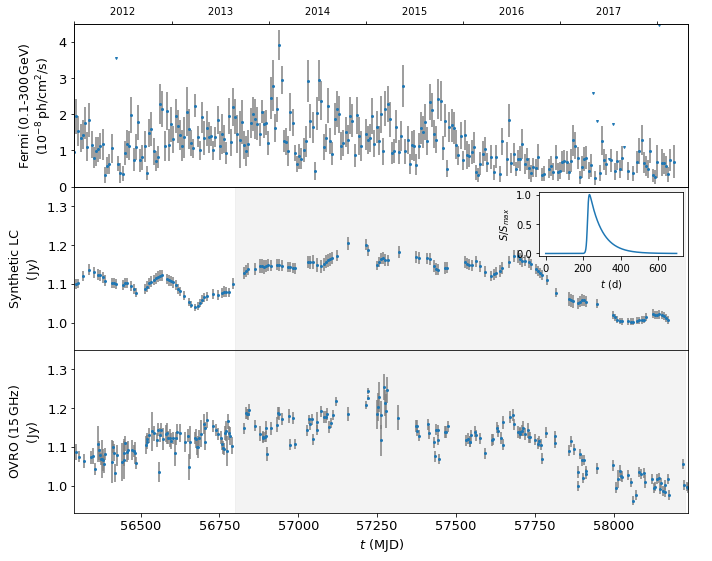

In [246]:
t = 224
x = [1665799.898661404, 3.355918705118255, 66.5926745199267, 0.9151354379043237]
print(t)
ylims = [[0, 0.45E-7], [0.93, 1.35], [0.93, 1.35], [None, None]]
result = get_fit(x, con_plot_mrk501, profile_st, t, True, extra_data=[gev_mrk501, None, None], plot_data=True, ylims=ylims, all_uncertainties=True, highlight=[56800, 58226], dst_data=radio_mrk501_orig, plot_timerange=mrk501_plot_timerange, color='#1f77b4', filename='images/gev_syn_radio_mrk501.eps')

In [218]:
#
# threshold 5.9 from https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html, dof=5, P(X<x)=0.68
# print(np.abs(x1 - x0) * 98, x0, x1)
#
params = [224, 1665799.898661404, 3.355918705118255, 66.5926745199267, 0.9151354379043237]
x0, dof = get_fit(params[1:], con_f7d1g, profile_st, params[0], True, all_uncertainties=True, get_dof=True)

for _p in range(len(params)):
    params1 = [i for i in params]
    res = []
    ps = []
    for p in np.linspace(0.5 * params[_p], 1.5 * params[_p], 1000):
        params1[_p] = p
        x1 = get_fit(params1[1:], con_f7d1g, profile_st, params1[0], True, all_uncertainties=True)
        res.append(np.abs(np.abs(x1 - x0) * dof - 5.9))
        ps.append(p)
    res = np.array(res)
    ps = np.array(ps)
    par = params[_p]
    m1 = ps[ps <= par][np.argmin(res[ps <= par])]
    m2 = ps[ps >= par][np.argmin(res[ps >= par])]
    print(f"{par} -{par - m1} +{m2 - par} || {m1} & {m2}")
    #plt.plot(ps, res, '-')
    #plt.ylim([0, 5.9])
    #plt.show()

224 -12.668668668668658 +3.0270270270270316 || 211.33133133133134 & 227.02702702702703
1665799.898661404 -29180.678905480076 +49190.287297809264 || 1636619.2197559238 & 1714990.1859592132
3.355918705118255 -1.6779593525591274 +1.6779593525591276 || 1.6779593525591274 & 5.0338780576773825
66.5926745199267 -1.4331756778562834 +1.5664943455638394 || 65.15949884207042 & 68.15916886549054
0.9151354379043237 -0.0041222317022717725 +0.0041222317022717725 || 0.911013206202052 & 0.9192576696065955


In [8]:
from scipy.signal import savgol_filter
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy import optimize
import matplotlib.pyplot as plt
import time

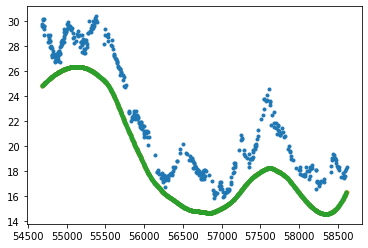

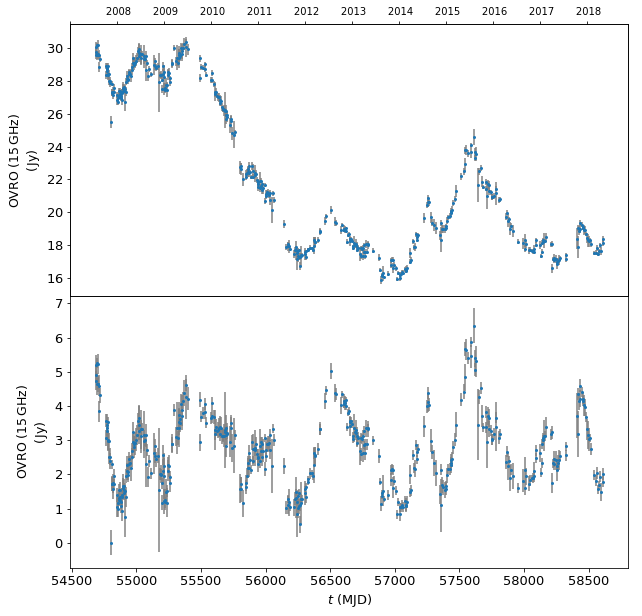

In [9]:
def data_resample(data, dt=3):

    obs_int = max(data['tc']) - min(data['tc'])
    n_samples = obs_int / dt
    samples = min(data['tc']) + np.arange(0, obs_int, dt)
    resampled_values = np.interp(samples, data['tc'], data['f'])
    return samples, resampled_values

def detrending(data, window=501, polyorder=3, dt=3):
    new_samples, resampled = data_resample(data, dt=dt)
    filtered = savgol_filter(resampled, window, polyorder)
    subtracted = data['f'] - np.interp(data['tc'], new_samples, filtered)
    m = np.min(subtracted)
    return data['tc'], subtracted - m, data['tc'], data['f'] - subtracted + m, new_samples, filtered + m
    #return data['tc'], subtracted, data['tc'], data['f'] - subtracted, new_samples, filtered


radio_3c273_dt_data = detrending(radio_3c273, dt=3)
plt.plot(radio_3c273['tc'], radio_3c273['f'], '.')
plt.plot(radio_3c273_dt_data[2], radio_3c273_dt_data[3], '.')
plt.plot(radio_3c273_dt_data[4], radio_3c273_dt_data[5], '.')
plt.show()

radio_3c273_dt = Table({k:radio_3c273[k] for k in radio_3c273.columns})
radio_3c273_dt['f'] = radio_3c273_dt_data[1]
radio_3c273_dt.meta = radio_3c273.meta
for c in radio_3c273.columns:
    radio_3c273_dt[c].unit = radio_3c273[c].unit
    
plot_lcs(radio_3c273, radio_3c273_dt)

3C 273 using UL


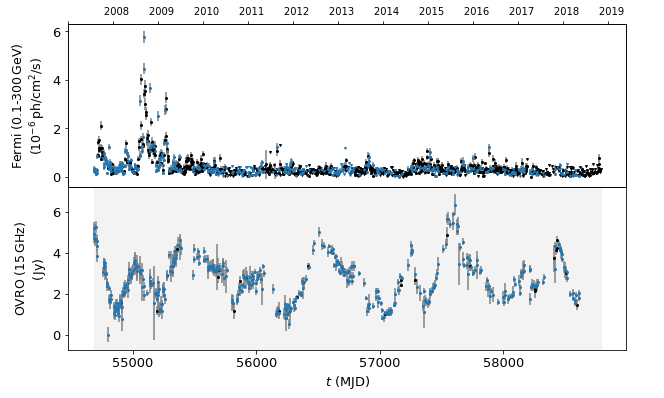

3C 273 using UL


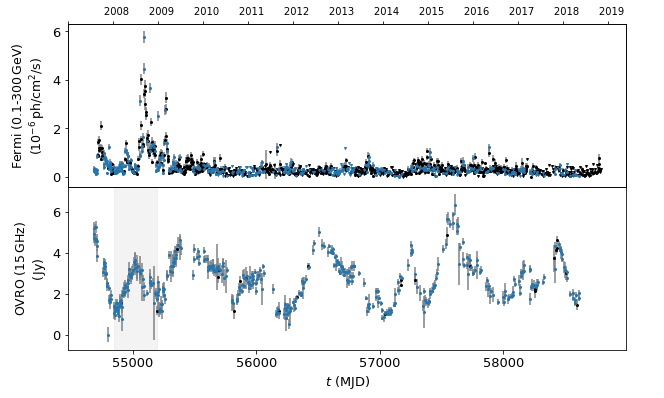

3C 273 using UL


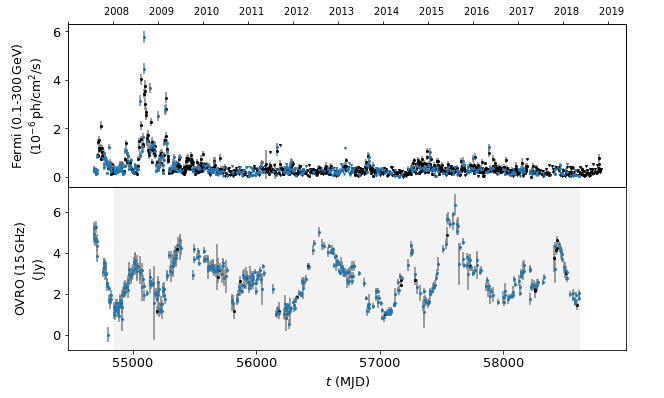

In [10]:
full_range=gev_3c273.meta['timerange']
flaring_period_1 = [54850, 55200]
flaring_period_X = [54850, radio_3c273.meta['timerange'][1]]

con_3c273_f0 = prepare_fit(gev_3c273, radio_3c273_dt, bin_size=3, fit_roi=full_range)
con_3c273_f1 = prepare_fit(gev_3c273, radio_3c273_dt, bin_size=3, fit_roi=flaring_period_1)
con_3c273_fX = prepare_fit(gev_3c273, radio_3c273_dt, bin_size=3, fit_roi=flaring_period_X)

In [25]:
bounds0 = [
    [1e-12, 1e12],  #Amp
    [1e-12, 1000], #t_rise
    [1e-12, 1000], #t_fall
    [1e-12, 10],   #rho
    [1e-12, 10],   #phi
]
bounds1 = [
    [1e-12, 1e12],  #Amp`
    [1e-12, 1e12], #t_rise
    [1e-12, 1e12],   #t_fall
    [-1e12, 1e12]
]
methods = ["Nelder-Mead", "Powell", "CG", "BFGS"]
b_methods = ["L-BFGS-B", "TNC", "COBYLA", "SLSQP", "trust-constr",]

res_7d = []
counter = 0
for r in np.arange(225, 300, 2):
    _v = optimize.minimize(
                              get_fit, 
                              #Amp, t_rise, t_fall, rho, phi, t_shift
                              #[3165694.19691723, 160.65039648429547, 3.313645265275364, 0.9201717829718753],
                              [97765.3421157885, 19.24416937907919, 42.883458356259524, 15.973314037084446],
                              args = (con_3c273_f1, profile_st, r, True, False), #configuration, profile_function, 
                                                                          #t_rise time, is_const_flux_present, all_uncertainties
                              method=b_methods[4], bounds=bounds1,
                              #method=methods[0],
                              options={'disp': False, 'maxiter': 10000, 'xtol': 1e-09}
                            )
    time.sleep(0.1)
    #if counter % 10 == 0:
    #    clear_output(wait=True)
    counter+=1
    print(r, "%.3f" % _v.fun, ", ".join(["%.3f" % i for i in _v.x]))
    res_7d.append([r, _v])

260.0 1.560 171735.594, 16.293, 32.614, 1.211
260.1 1.560 171786.215, 16.289, 32.556, 1.211
260.20000000000005 1.560 171836.873, 16.284, 32.498, 1.211


<ipython-input-5-4fb456198fb8>:3: RuntimeWarning: overflow encountered in exp
  return Amp * np.exp(-t/t_fall) / (1 + np.exp(-t/t_rise))


260.30000000000007 1.560 171887.874, 16.280, 32.439, 1.211
260.4000000000001 1.560 171930.493, 16.276, 32.382, 1.211
260.5000000000001 1.560 171970.821, 16.272, 32.325, 1.210
260.60000000000014 1.560 172033.224, 16.266, 32.265, 1.210
260.70000000000016 1.560 172084.179, 16.261, 32.206, 1.210
260.8000000000002 1.559 172131.726, 16.256, 32.148, 1.210
260.9000000000002 1.559 172179.747, 16.251, 32.090, 1.210
261.0000000000002 1.559 172226.033, 16.246, 32.032, 1.210
261.10000000000025 1.559 172274.587, 16.241, 31.974, 1.210
261.2000000000003 1.559 172319.537, 16.236, 31.917, 1.210
261.3000000000003 1.559 172364.779, 16.231, 31.859, 1.210
261.4000000000003 1.559 172412.497, 16.226, 31.801, 1.210
261.50000000000034 1.559 172458.493, 16.220, 31.743, 1.210
261.60000000000036 1.559 172500.911, 16.215, 31.686, 1.209
261.7000000000004 1.559 172541.826, 16.210, 31.629, 1.209
261.8000000000004 1.559 172589.447, 16.205, 31.571, 1.209
261.90000000000043 1.559 172633.197, 16.199, 31.513, 1.209
262.000

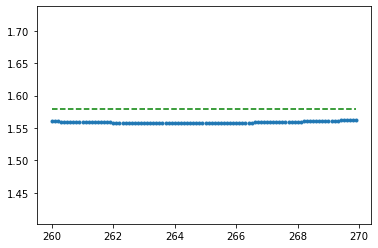

264.300000000001 1.557681980592832 [173559.26207451118, 16.054813958528577, 30.147199911268235, 1.2066084948243785]
items:  100
260.00 1.5603 [171735.59429816125, 16.29343071067309, 32.61435147797004, 1.2109062123500745]
1.5167958470849536
260.10 1.5602 [171786.21466594204, 16.288914903591508, 32.555966244213586, 1.2108167683527074]
1.5166855575849807
260.20 1.5601 [171836.8728756361, 16.284315578911123, 32.49755394875899, 1.210726826677451]
1.5165778755968473
260.30 1.5600 [171887.87375651233, 16.2796080998864, 32.43906334118215, 1.2106363377172276]
1.5164727223761703
260.40 1.5599 [171930.49263259236, 16.27552471795313, 32.382068584016885, 1.2105455151086266]
1.5163723714640032
260.50 1.5598 [171970.82068641376, 16.27155417915607, 32.32546554948779, 1.2104541228962775]
1.5162752483136603
260.60 1.5596 [172033.22405257344, 16.265645618088897, 32.26485525211333, 1.2103620075085983]
1.5161749944037495
260.70 1.5595 [172084.17883373905, 16.260619274125865, 32.20629503071173, 1.2102695578

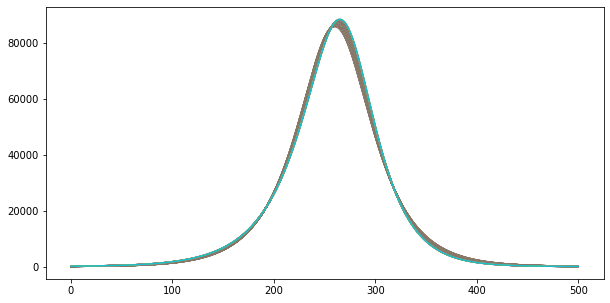

In [26]:
data = res_7d

min_chi2dof, max_chi2dof = 1.4, 1.58
ts, xs, fun = np.array([i[0] for i in data]), np.array([i[1].x for i in data]), np.array([i[1].fun for i in data])
plot_y_limits = [0.9*np.min(fun), 1.1*max_chi2dof]
#plot_y_limits = [0.9*np.min(fun), None]

plt.plot(ts, fun, '.')
plt.hlines(max_chi2dof, np.min(ts), np.max(ts), color='green', linestyle='dashed')
plt.hlines(min_chi2dof, np.min(ts), np.max(ts), color='green', linestyle='solid')
plt.ylim(plot_y_limits)
plt.show()

print(ts[np.argmin(fun)], np.min(fun), list(xs[np.argmin(fun)]))

m = np.logical_and(fun >= min_chi2dof, fun <= max_chi2dof)
xs, ts = xs[m], ts[m]
_f = fun[m]
print("items: ", len(xs))
fig = plt.figure(figsize=(10, 5))
x = np.linspace(0, 500, 1000)
for t, f, v in zip(ts, _f, xs):
    print("%.2f" % t, "%.4f" % f, list(v))
    #params = list(v) + [t]
    #const_flux = 0
    #const_flux_present=False
    params = list(v[:-1]) + [t]
    const_flux = v[-1]
    const_flux_present=True
    plt.plot(x, profile_st(x, *params) + const_flux, '-')
    xi2 = get_fit(v, con_3c273_f1, profile_st, t, const_flux_present, all_uncertainties=True)
    print(xi2)
plt.show()

chi2/dof = 19859.121890164904/426 = 46.617657019166444, params = [173791.48644003057, 16.006590929982114, 29.75253588490902, 265, 1.2058239164842008], t_shift=265
3C 273 using UL


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


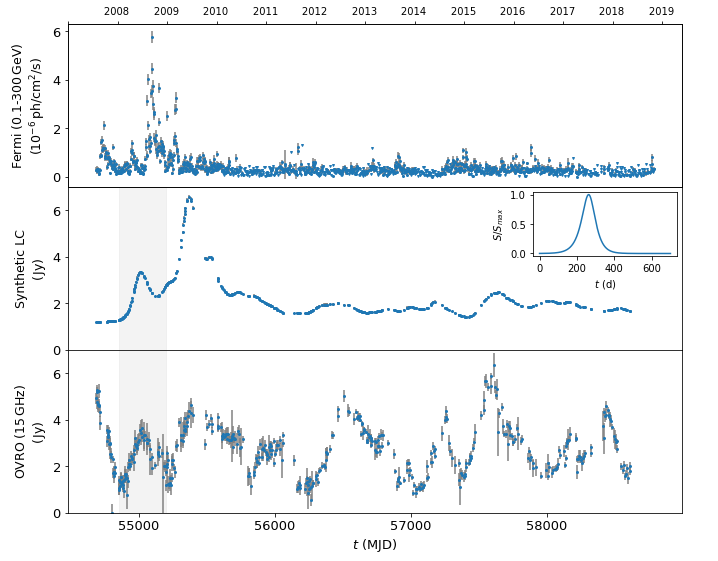

In [11]:
t = 265
x = [173791.48644003057, 16.006590929982114, 29.75253588490902, 1.2058239164842008]
ylims = [[None, None], [0, 7], [0, 7], [None, None]]
#result = get_fit(x, con_3c273_f1, profile_st, t, True, extra_data=[gev_3c273, None, None], plot_data=True, ylims=ylims, all_uncertainties=True, highlight=[flaring_period_1], dst_data=radio_3c273_orig, color='#1f77b4', filename='images/gev_syn_radio_mrk501.eps')

result = get_fit(x, con_3c273_f0, profile_st, t, True, flare_tuning=None, extra_data=[gev_3c273, None, None], plot_data=True, ylims=ylims, all_uncertainties=True, highlight=[flaring_period_1], dst_data=radio_3c273_dt, color='#1f77b4', filename='images/gev_syn_radio_3c273.eps')

In [452]:
#
# threshold 5.9 from https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html, dof=5, P(X<x)=0.68
# print(np.abs(x1 - x0) * 98, x0, x1)
#
params = [264.3, 173559.26207451118, 16.054813958528577, 30.147199911268235, 1.2066084948243785]
x0, dof = get_fit(params[1:], con_3c273_f1, profile_st, params[0], True, all_uncertainties=True, get_dof=True)

for _p in range(len(params)):
    params1 = [i for i in params]
    res = []
    ps = []
    for p in np.linspace(0.5 * params[_p], 1.5 * params[_p], 1000):
        params1[_p] = p
        x1 = get_fit(params1[1:], con_3c273_f1, profile_st, params1[0], True, all_uncertainties=True)
        res.append(np.abs(np.abs(x1 - x0) * dof - 5.9))
        ps.append(p)
    res = np.array(res)
    ps = np.array(ps)
    par = params[_p]
    m1 = ps[ps <= par][np.argmin(res[ps <= par])]
    m2 = ps[ps >= par][np.argmin(res[ps >= par])]
    print(f"{par} -{par - m1} +{m2 - par} || {m1} & {m2}")
    #plt.plot(ps, res, '-')
    #plt.ylim([0, 5.9])
    #plt.show()

264.3 -6.481831831831812 +6.217267267267289 || 257.8181681681682 & 270.5172672672673
173559.26207451118 -11032.045186918374 +12248.176152405475 || 162527.2168875928 & 185807.43822691665
16.054813958528577 -0.6508708361565638 +0.6187290664698182 || 15.403943122372013 & 16.673543024998395
30.147199911268235 -2.097327721554695 +2.8517621537686217 || 28.04987218971354 & 32.99896206503686
1.2066084948243785 -0.07065725420142766 +0.07307288682369872 || 1.1359512406229508 & 1.2796813816480772


In [12]:
minimization_parameters = [173559.26207451118, 16.054813958528577, 30.147199911268235, 1.2066084948243785]
delta_t = 264.3

flaring_periods = [
    [54684, 54890],
    [54890, 55340],
    [55340, 56125],
    [56125, 56530],
    [56530, 56920],
    [56920, 57250],
    [57250, 57710],
    [57710, 57910],
    [57910, 58110],
    [58110, 58610],
]

def find_flare_amplitudes(p, plot=False, detrend=False, flaring_periods=flaring_periods): 
    ylims = [[None, None], [14.5, 34], [14.5, 34], [None, None]]
    if detrend == False:
        ylims = [[None, None], [0, 6], [0, 6], [None, None]]
        
    flare_tuning = [[flaring_periods[i], p[i]] for i in range(len(flaring_periods))]

    def background(x, const):
        f = np.interp(x, radio_3c273_dt_data[4], radio_3c273_dt_data[5]) 
        if detrend == False:
            f = 0
        flux = np.ones_like(x) * const + f
        return flux

    def extra_plot(ax):
        ax[1].plot(radio_3c273_dt_data[4], radio_3c273_dt_data[5], linestyle='dotted', marker=None, color='grey')
        ax[2].plot(radio_3c273_dt_data[4], radio_3c273_dt_data[5], linestyle='dotted', marker=None, color='grey')
    
    if detrend == False:
        return get_fit(minimization_parameters, con_3c273_fX, profile_st, delta_t, True, extra_plot=extra_plot, flare_tuning=flare_tuning, background=None, extra_data=[gev_3c273, None, None], plot_data=plot, ylims=ylims, all_uncertainties=False, highlight=[flaring_period_X], plot_timerange=full_range, dst_data=radio_3c273_dt, plot_flares=plot, color='#1f77b4', filename='images/gev_syn_radio_3c273.eps')
    else:
        return get_fit(minimization_parameters, con_3c273_f0, profile_st, delta_t, True, extra_plot=extra_plot, flare_tuning=flare_tuning, background=background, extra_data=[gev_3c273, None, None], plot_data=plot, ylims=ylims, all_uncertainties=False, highlight=[flaring_period_X], plot_timerange=full_range, dst_data=radio_3c273_orig, plot_flares=plot, color='#1f77b4', filename='images/gev_syn_radio_3c273.eps')

In [13]:
p0 = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
find_flare_amplitudes(p0)

44.241740518226

In [14]:
methods = ["Nelder-Mead", "Powell", "CG", "BFGS"]
b_methods = ["L-BFGS-B", "TNC", "COBYLA", "SLSQP", "trust-constr",]


boundsp = [[0.01, 1e12]] * len(flaring_periods)

_v = optimize.minimize(
                              find_flare_amplitudes, 
                              [10] * len(flaring_periods),
                              method=b_methods[4], bounds=boundsp,
                              args=(False, False)
                              #method=methods[3],
                              #options={'disp': False, 'maxiter': 10000, 'xtol': 1e-09}
                            )
_v

 barrier_parameter: 2.048000000000001e-09
 barrier_tolerance: 2.048000000000001e-09
          cg_niter: 349
      cg_stop_cond: 2
            constr: [array([1.07152338, 0.69062623, 1.38889905, 5.30626631, 0.46273848,
       5.29184684, 2.71201835, 0.8810725 , 3.49641907, 2.41806972])]
       constr_nfev: [0]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 17.483660459518433
               fun: 10.41404693217679
              grad: array([0.00000000e+00, 1.19209290e-07, 0.00000000e+00, 2.24657570e-08,
       1.19209290e-07, 0.00000000e+00, 4.39559304e-08, 1.19209290e-07,
       3.40946800e-08, 4.92993600e-08])
               jac: [<10x10 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>]
   lagrangian_grad: array([-1.02217759e-09,  3.67879382e-08, -9.73330692e-10,  2.13190441e-08,
        1.95086455e-08, -3.74325473e-10,  3.79939691e-08,  5.04149438e-08,
        3

In [15]:
_v.x

array([1.07152338, 0.69062623, 1.38889905, 5.30626631, 0.46273848,
       5.29184684, 2.71201835, 0.8810725 , 3.49641907, 2.41806972])

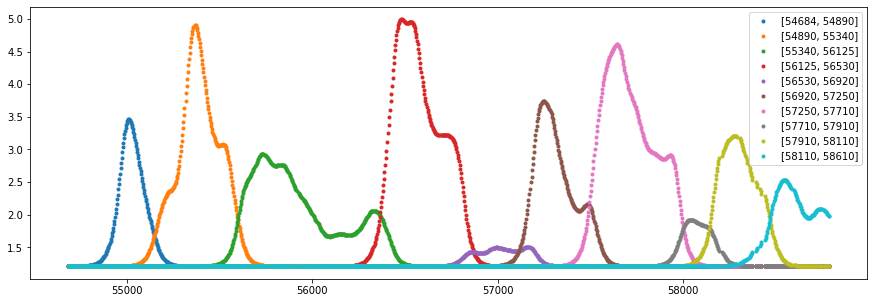

chi2/dof = 4505700.540764936/426 = 10576.76183278154, params = [173559.26207451118, 16.054813958528577, 30.147199911268235, 264.3, 1.2066084948243785], t_shift=264.3
3C 273 using UL


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


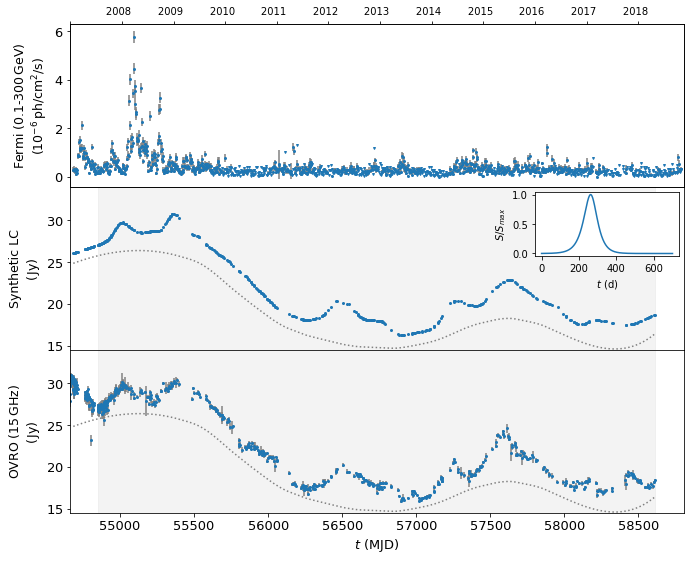

In [16]:
params = _v.x
result = find_flare_amplitudes(params, plot=True, detrend=True)

In [749]:
x0, dof = find_flare_amplitudes(params, plot=False, detrend=False), 426

for _p in range(len(params)):
    params1 = [i for i in params]
    res = []
    ps = []
    for p in np.linspace(0.5 * params[_p], 1.5 * params[_p], 1000):
        params1[_p] = p
        x1 = find_flare_amplitudes(params1, plot=False, detrend=False)
        res.append(np.abs(np.abs(x1 - x0) * dof - 11.5))
        ps.append(p)
    res = np.array(res)
    ps = np.array(ps)
    par = params[_p]
    m1 = ps[ps <= par][np.argmin(res[ps <= par])]
    m2 = ps[ps >= par][np.argmin(res[ps >= par])]
    print(f"{flaring_periods[_p][0]}-{flaring_periods[_p][1]} & {par:.3f} -{par - m1:.3f} +{m2 - par:.3f} || {m1} & {m2}")

54684-54890 & 1.072 -0.101 +0.101 || 0.9701630630902509 & 1.17288370313896
54890-55340 & 0.691 -0.041 +0.041 || 0.6494928322431576 & 0.7317596199354788
55340-56125 & 1.389 -0.084 +0.084 || 1.3047865409168304 & 1.4730115504543226
56125-56530 & 5.306 -0.157 +0.157 || 5.149574762588962 & 5.462957857991487
56530-56920 & 0.463 -0.145 +0.145 || 0.3179879577612675 & 0.6074890118046647
56920-57250 & 5.292 -0.442 +0.442 || 4.849535313305424 & 5.7341583578952715
57250-57710 & 2.712 -0.118 +0.118 || 2.593927464644448 & 2.8301092432149
57710-57910 & 0.881 -0.167 +0.167 || 0.7139421322875138 & 1.0482028711843239
57910-58110 & 3.496 -0.278 +0.278 || 3.2181755106127987 & 3.774662629903103
58110-58610 & 2.418 -0.287 +0.287 || 2.131241633602741 & 2.704897814368044


3C 273 using UL


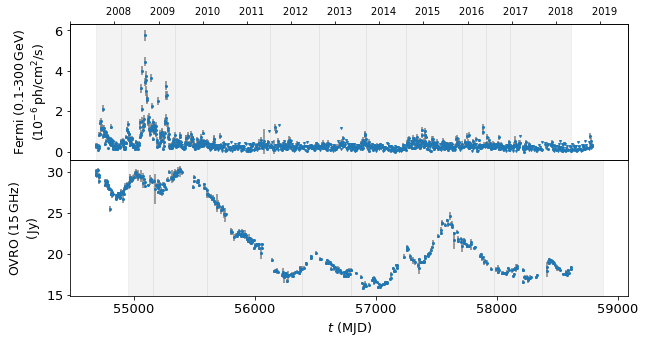

In [17]:
highlights = [flaring_periods,None]

highlights[1] = (np.array(highlights[0]) + delta_t).tolist()

plot_lcs(gev_3c273, radio_3c273, highlights=highlights, figsize=(10,5))

In [32]:
def generate_random_flaring_periods(timerange, periods_number=10):
    start_t, end_t = timerange[0], timerange[1]
    _t = np.sort(np.random.randint(int(start_t), high=int(end_t), size=periods_number - 1))
    periods = []
    for i in range(periods_number - 1):
        if i == 0:
            periods.append([start_t, _t[i]])
        else:
            periods.append([_t[i - 1], _t[i]])
    periods.append([_t[periods_number - 2], end_t])
    return periods

In [33]:
def perform_mc(x=None):
    if x is None:
        x = int(("%s" % int(time.time()*10))[-6:])
    np.random.seed(x)
    fp = generate_random_flaring_periods(gev_3c273.meta['timerange'], 10)
    #highlights = [fp,None]
    #highlights[1] = (np.array(highlights[0]) + delta_t).tolist()
    #plot_lcs(gev_3c273, radio_3c273, highlights=highlights, figsize=(10,5))
    boundsp = [[0.01, 36]] * len(fp)

    _v = optimize.minimize(
                                  find_flare_amplitudes, 
                                  [10] * len(fp),
                                  method=b_methods[4], bounds=boundsp,
                                  args=(False, False, fp)
                                  #method=methods[3],
                                  #options={'disp': False, 'maxiter': 10000, 'xtol': 1e-09}
                                )
    #print("->", _v.fun, _v.x, fp)
    filename = "/local/vitalii/analysis/gev-radio/tmp/mc_%s.dat" % x
    with open(filename, "a+") as f:
        f.write(f"-> {_v.fun}\t{_v.x}\t{fp}\n")

In [ ]:
import multiprocessing
pool = multiprocessing.Pool(32)
total_tasks = 10000
tasks = range(total_tasks)
results = pool.map_async(perform_mc, tasks)
pool.close()
pool.join()

/data/vitalii/software/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/data/vitalii/software/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/data/vitalii/software/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by

/data/vitalii/software/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/data/vitalii/software/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/data/vitalii/software/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by